# Topic Modeling and Classification of Customer Complaints 

## **Table of Contents** 

1. **Problem Statement** 


2. **Essential Comments**


3. **Import Libraries and Modules** 


4. **Load JSON Data as Pandas DataFrame** 


5. **Exploratory Data Analysis and Data Preprocessing**

    - 5.1 Data Exploration 
    - 5.2 Data Exploration Summary
    - 5.3 Data Preprocessing
    - 5.4 Visualization of Preprocessed Data


6. **Topic Modeling with TF-IDF Vectorization and NMF**
    
    - 6.1 Vectorize Raw Texts to TF-IDF Feature Matrix
    - 6.2 Find Optimal Number of Topic with NMF
    - 6.3 Manual Topic Modeling with NMF


7. **Build Supervised Model to Classify New Complaints**
    
    - 7.1 Predictive Classifier 1: Multinomial Naive Bayes
    - 7.2 Predictive Classifier 2: Logistic Regression
    - 7.3 Predictive Classifier 3: Decision Tree
    - 7.4 Predictive Classifier 4: Random Forest


8. **Conclusions** 

## **1. Problem Statement**

Build a model that can classify customer complaints based on the product/service. This will allow the segreggation of these complaints (or tickets) to their relevant categories (or topics), thereby helping in the quick resolution of an issue.


We will be doing topic modeling on a consumer complaints data set. Since the data is not labeled, we will be applying the non-negative matrix factorization (**NMF**) approach for topic modeling of consumer complaints and clustering them into one of the following five categories:

- **Credit/Prepaid Card**
- **Bank Account Services**
- **Theft/Dispute Reporting**
- **Mortgages/Loans**
- **Others**

With the aid of topic modeling, we will be able to map each ticket onto the respective department/category. We will then use this data to train any classifier such as *logistic regression*, *decision tree*, or *random forest*. Finally, using the trained classifier we will classify any new customer complaint support ticket to the relevant department. 

## **2. Essential Comments**

1. If you are running this notebook on Google Colab, uncomment the first cell in the section below, called **"Import Required Libraries and Modules"**, and run the notebook end-to-end.

2. If you are running this notebook on a local or virtual machine, make sure to create a new virtual or `conda` environment, install all required libraies, and then run the notebook end-to-end. 

3. Make sure that you use `gensim==4.0` package if you want to use the `nmf` model available in `gensim.models`. The `NMF.py` file is not available in `gensim.models` with old versions of gensim such as `gensim==3.6` or `gensim==3.8`.

4. The most time consuming parts of this notebook are the lemmatization step present in "**Exploratory Data Analysis and Data Preprocessing**" and the NMF step in **"Topic Modeling with TF-IDF Vectorization and NMF"**. One can in principle, decrease this time with either/both the following approaches:

    - The **stemming** approach (from `nltk` package) of wrapping the **lemmatization** step with other data preprocessing steps into a `spaCy` **pipeline**. 

    - Using a subset of the "non-empty" ("non-blank") consumer complaints instead of the whole data set of around 22,000 records.

## **3. Import Required Libraries and Modules**

In [ ]:
!python3 -m spacy download en_core_web_sm --quiet
!python -m textblob.download_corpora --quiet
!python3 -m pip install gensim==4.0 --quiet

     |████████████████████████████████| 12.8 MB 14.6 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.
     |████████████████████████████████| 23.9 MB 1.4 MB/s 


In [ ]:
# Builtin libraries
import os
import warnings
import json
import re
import string
import IPython as ipy
import pickle
import pprint

# Third-party libraries for data science
# and machine learning 
import numpy as np
import pandas as pd
import matplotlib as mpl 
import seaborn as sns
import plotly
import sklearn as skl 

# Third-party NLP libraries
import nltk
import spacy
import en_core_web_sm
import textblob
import wordcloud
import gensim

/usr/local/lib/python3.8/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [ ]:
print(f'{"re --version":{20}} : {re.__version__:s}')
print(f'{"json --version":{20}} : {json.__version__:s}')
print(f'{"nltk --version":{20}} : {nltk.__version__:s}')
print(f'{"spacy --version":{20}} : {spacy.__version__:s}')
print(f'{"ipython --version":{20}} : {ipy.__version__:s}')
print(f'{"numpy --version":{20}} : {np.__version__:s}')
print(f'{"pandas --version":{20}} : {pd.__version__:s}')
print(f'{"matplotlib --version":{20}} : {mpl.__version__:s}')
print(f'{"seaborn --version":{20}} : {sns.__version__:s}')
print(f'{"plotly --version":{20}} : {plotly.__version__:s}')
print(f'{"sklearn --version":{20}} : {skl.__version__:s}')
print(f'{"textblob --version":{20}} : {textblob.__version__:s}')
print(f'{"wordcloud --version":{20}} : {wordcloud.__version__:s}')
print(f'{"gensim --version":{20}} : {gensim.__version__:s}')

re --version         : 2.2.1
json --version       : 2.0.9
nltk --version       : 3.7
spacy --version      : 3.4.4
ipython --version    : 7.9.0
numpy --version      : 1.21.6
pandas --version     : 1.3.5
matplotlib --version : 3.2.2
seaborn --version    : 0.11.2
plotly --version     : 5.5.0
sklearn --version    : 1.0.2
textblob --version   : 0.15.3
wordcloud --version  : 1.8.2.2
gensim --version     : 4.0.0


In [ ]:
warnings.filterwarnings(action='ignore')

In [ ]:
from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from matplotlib import pyplot as plt 

from sklearn.model_selection import train_test_split as tts 
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer 
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn import decomposition as decomp

from plotly import offline as plot
from plotly import graph_objects as go
from plotly import express as px

from pprint import pprint

from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS

from gensim.corpora.dictionary import Dictionary
from gensim.models import nmf, CoherenceModel 
from gensim.models.coherencemodel import CoherenceModel
from operator import itemgetter

In [ ]:
nlp_model = en_core_web_sm.load()

## **4. Load JSON Data as Pandas DataFrame** 

In [ ]:
!pwd 
!wget -nv https://raw.githubusercontent.com/rs2pydev/nlp_1_CLFwTM/main/data/Client_data.json
!ls 

/content
2023-01-02 06:30:30 URL:https://raw.githubusercontent.com/rs2pydev/nlp_1_CLFwTM/main/data/Client_data.json [83392514/83392514] -> "Client_data.json" [1]
Client_data.json  sample_data


In [ ]:
with open("./Client_data.json") as f_handle:
    json_data = json.load(f_handle)

In [ ]:
df = pd.json_normalize(json_data) 

## **5. Exploratory Data Analysis and Data Preprocessing**

### 5.1 Data Exploration 

In [ ]:
# Display dataset
display(df.sample(n=10))

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
70603,complaint-public-v2,complaint,2253096,0.0,None,606XX,2253096,Deposits and withdrawals,2016-12-16T12:00:00-05:00,IL,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2016-12-16T12:00:00-05:00,None,Checking account,Yes,This is a compliant against Chase. \nI deposit...,None,Consent provided
10665,complaint-public-v2,complaint,3530100,0.0,None,11204,3530100,Closing your account,2020-02-13T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2020-02-13T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Company closed your account,Consent not provided
60903,complaint-public-v2,complaint,55009,0.0,Older American,01886,55009,Collection practices,2011-12-19T12:00:00-05:00,MA,...,Closed without relief,JPMORGAN CHASE & CO.,Web,2011-12-21T12:00:00-05:00,None,None,Yes,,None,N/A
29161,complaint-public-v2,complaint,3199330,0.0,None,30088,3199330,Problem with a lender or other company chargin...,2019-04-02T12:00:00-05:00,GA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,Checking account,Yes,,Money was taken from your account on the wrong...,Consent not provided
42691,complaint-public-v2,complaint,731481,0.0,None,95746,731481,"Loan servicing, payments, escrow account",2014-02-24T12:00:00-05:00,CA,...,Closed,JPMORGAN CHASE & CO.,Referral,2014-02-26T12:00:00-05:00,None,Other mortgage,Yes,,None,N/A
28292,complaint-public-v2,complaint,3336364,0.0,None,936XX,3336364,Problem with a lender or other company chargin...,2019-08-10T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-08-10T12:00:00-05:00,None,Checking account,Yes,I lost my debit card with a sticky note attach...,Transaction was not authorized,Consent provided
18685,complaint-public-v2,complaint,221484,0.0,None,21113,221484,"Loan modification,collection,foreclosure",2013-01-03T12:00:00-05:00,MD,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2013-01-04T12:00:00-05:00,None,Other mortgage,Yes,,None,N/A
70239,complaint-public-v2,complaint,1462549,0.0,None,60079,1462549,Using a debit or ATM card,2015-07-10T12:00:00-05:00,IL,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2015-07-10T12:00:00-05:00,None,Checking account,Yes,I was frauded against and when I filed a claim...,None,Consent provided
71039,complaint-public-v2,complaint,2434012,0.0,None,20009,2434012,Billing statement,2017-04-13T12:00:00-05:00,DC,...,Closed with explanation,JPMORGAN CHASE & CO.,Fax,2017-04-14T12:00:00-05:00,None,None,Yes,,None,N/A
3759,complaint-public-v2,complaint,2566838,0.0,None,327XX,2566838,Problem with a purchase shown on your statement,2017-07-06T12:00:00-05:00,FL,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-07-06T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,"I placed an order with an online merchant, XXX...",Credit card company isn't resolving a dispute ...,Consent provided


In [ ]:
# Check number of rows and columns in dataset
print(df.shape)

(78313, 22)


In [ ]:
# Variables' information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [ ]:
# Identify and collect null columns
null_cols = [var for var in df.columns if df[var].isnull().sum() > 0]
print(*null_cols, sep='\n', end='\n\n')
display(df[null_cols].isnull().sum())

_source.tags
_source.zip_code
_source.state
_source.company_public_response
_source.sub_product
_source.sub_issue
_source.consumer_consent_provided



_source.tags                         67413
_source.zip_code                      6757
_source.state                         1991
_source.company_public_response      78309
_source.sub_product                  10571
_source.sub_issue                    46297
_source.consumer_consent_provided     1008
dtype: int64

In [ ]:
# Identify and collect non-null columns
not_null_cols = [var for var in df.columns if df[var].isnull().sum() == 0]
print(*not_null_cols, sep='\n', end='\n\n')
display(df[not_null_cols].isnull().sum())

_index
_type
_id
_score
_source.complaint_id
_source.issue
_source.date_received
_source.consumer_disputed
_source.product
_source.company_response
_source.company
_source.submitted_via
_source.date_sent_to_company
_source.timely
_source.complaint_what_happened



_index                             0
_type                              0
_id                                0
_score                             0
_source.complaint_id               0
_source.issue                      0
_source.date_received              0
_source.consumer_disputed          0
_source.product                    0
_source.company_response           0
_source.company                    0
_source.submitted_via              0
_source.date_sent_to_company       0
_source.timely                     0
_source.complaint_what_happened    0
dtype: int64

In [ ]:
# Create list of column names
col_names = df.columns.to_list()
print('Column Names: ')
print(*col_names, sep="\n", end='\n')

Column Names: 
_index
_type
_id
_score
_source.tags
_source.zip_code
_source.complaint_id
_source.issue
_source.date_received
_source.state
_source.consumer_disputed
_source.product
_source.company_response
_source.company
_source.submitted_via
_source.date_sent_to_company
_source.company_public_response
_source.sub_product
_source.timely
_source.complaint_what_happened
_source.sub_issue
_source.consumer_consent_provided


In [ ]:
def value_count_df(df:pd.DataFrame=None, var:str=None) -> pd.DataFrame:
    """
    Given a Pandas DataFrame and a column name, this function displays 
    the items in the column and their counts (frequencies).
    Args:
        df: pd.DataFrame | Default value None
        var: str | Default value None
    Return:
        pd.DataFrame
    """
    new_df = pd.DataFrame()
    new_df = df[var].value_counts().reset_index()
    new_df.columns = [str(var), 'Count']
    return new_df

In [ ]:
# Check distributions of columns of interest
vars = [
    '_source.product', 
    '_source.issue', 
    '_source.complaint_what_happened'
]

for var in vars:
    tmp = pd.DataFrame()
    tmp = value_count_df(df=df, var=var)
    print(f'For variable `{var:s}`: ')
    display(tmp)
    print()

For variable `_source.product`: 


,_source.product,Count
0,Mortgage,22725
1,Checking or savings account,12147
2,Credit card or prepaid card,10797
3,Credit card,10373
4,Bank account or service,9816
5,"Credit reporting, credit repair services, or o...",4310
6,Debt collection,3201
7,"Money transfer, virtual currency, or money ser...",1500
8,Consumer Loan,1029
9,Vehicle loan or lease,892



For variable `_source.issue`: 


,_source.issue,Count
0,"Loan modification,collection,foreclosure",9743
1,Managing an account,7410
2,"Loan servicing, payments, escrow account",5360
3,Problem with a purchase shown on your statement,4055
4,"Account opening, closing, or management",3879
...,...,...
149,Unable to get credit report/credit score,1
150,"Advertising, marketing or disclosures",1
151,Problem with an overdraft,1
152,Can't stop withdrawals from your bank account,1



For variable `_source.complaint_what_happened`: 


,_source.complaint_what_happened,Count
0,,57241
1,Chase has violated 15 USC 1692 by continuing c...,11
2,"Hello, I was an authorized user on a relative ...",9
3,I filed a dispute in regards to the incorrect ...,7
4,This particular account situation that is late...,7
...,...,...
20926,CREDIT FROM CHASE IS SUPPOSED TO BE IN THE FOR...,1
20927,My husband and I opened a Home Equity loan wit...,1
20928,XX/XX/XXXX The background of this compliant is...,1
20929,I deposited a large check into my account on X...,1


In [ ]:
# We will examine the consumer complaints column to check for
# null values hidden as empty strings
print('Non-empty items: ')
display(df.loc[(df['_source.complaint_what_happened'] != ''), :].shape)
print('Empty items: ')
display(df.loc[(df['_source.complaint_what_happened'] == ''), :].shape)

Non-empty items: 


(21072, 22)

Empty items: 


(57241, 22)

### 5.2 Data Exploration Summary

* The dataset has 78313 customer complaints and 22 features with the customer complaint is in `_source.complaint_what_happened` column.

* Using the 21072 non-empty (non-blank) rows of the `_source.complaint_what_happened` column, we will create a DataFrame called `df_text`. **NOTE:** 57241 rows of this column are empty (blank). 

* Next, we rename the `df_text` column.

* Finally, we apply text preprocessing (see below) on `df_text.complaints_unclean` and create a new column, `complaints_clean`. 
    * Convert text to lowercase.
    * Remove text in square brackets.
    * Remove punctuations.
    * Remove words containing numbers.
    * Remove all *hidden* words, containing `XXX`
    * Use POS tags to get relevant words from the texts - We will use nouns only.
    * Lemmatize the texts.

### 5.3 Data Preprocessing

In [ ]:
df_text = pd.DataFrame()
df_text = pd.DataFrame(df.loc[(df['_source.complaint_what_happened'] != ''), 
                 '_source.complaint_what_happened']).reset_index(drop=True)
df_text.rename(columns={'_source.complaint_what_happened': 'complaints_unclean'}, 
               inplace=True)
display(df_text.sample(n=10))

,complaints_unclean
15819,I deal with Jpmorgan chase with my mortgage co...
7622,My wife and I were honeymooning in XXXX over...
14401,We are filing a complaint against Chase. We ha...
218,I hope that you can help me with my issue with...
11993,There was a transfer of funds from my Chase ch...
4643,I saw two inquires on my report that I don't r...
20876,I have 12 hard inquiries according to XXXX XXX...
18424,I had previously submitted a complaint in XXXX...
19703,"XXXX of Virginia, operating by and through JPM..."
19892,I have a Chase Freedom Unlimited card and I re...


In [ ]:
def text_cleaner(text:str=None) -> str:
    '''
    Make text lowercase, remove text in square brackets, remove punctuation 
    and remove words containing numbers.
    Args:
        text: str | Default value None
    Returns:
        str 
    '''
    text = text.lower() # Make word lowercase
    text = re.sub(r'\[.*?\]', '', text)  # Remove word in square brackets
    text = re.sub(r'\w*\d\w*', '', text) # Remove words with digits 
    text = re.sub(r'x{4}|xx/', '', text) # Remove words with 'XXXX' | 'XX/' 
    text = re.sub(r'\n', '', text) # Remove new lines
    text = re.sub(r'\b\w{1,3}\b', '', text) # Remove all 1-, 2-, and 3-letter words
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text) # Remove punctuations
    return text

In [ ]:
df_text['complaints_clean'] = df_text['complaints_unclean'].apply(lambda x: text_cleaner(x))

In [ ]:
pd.set_option('display.max_colwidth', -1)
display(df_text.sample(n=5))

,complaints_unclean,complaints_clean
7993,"I obtained inflight offer to earn XXXX bonus miles after spending {$3000.00} in the first three months with XXXX XXXX XXXX XXXX XXXX XXXX XXXX credit card. Chase didnt approve my application based on too many credit cards open in the last two years. \nAccording to terms and conditions on the application : this product is not available to either ( 1 ) current card member of this credit card- which I am not, or ( 2 ) previous card member of credit card who received a new card member bonus for this card within the last 24 months-which I had closedmore then 24 month ago on XX/XX/2016. See attached. \nThe conversation with the supervisor of Chase was fruitless. \nChase implemented the criteria : if you open more then five general credit cards in the last 24 months, youll be rejected, but they never disclosed it. \nIn my case I had two store cards that is not supposed be accounted. \nNot fully disclosing ALL the conditions is a violation of the TRUTH IN LENDING ACT.",obtained inflight offer earn bonus miles after spending first three months with credit card chase didnt approve application based many credit cards open last years according terms conditions application this product available either current card member this credit card which previous card member credit card received card member bonus this card within last monthswhich closedmore then month attached conversation with supervisor chase fruitless chase implemented criteria open more then five general credit cards last months youll rejected they never disclosed case store cards that supposed accounted fully disclosing conditions violation truth lending
2118,"I found out that my card was stolen when reviewing the statement. I made a call to bank to stop and ask for a replacement. This happened around an hour after that charge was done ( which should fall within 24 hours, and showing my due diligent reviewing my statement on a daily basis ). \n\nOn XX/XX/XXXX I received a letter informing me that the investigation has been done and that I end up being responsible for these two unauthorized charges because they used the card, {$98.00}, and {$61.00} because I "" benefit from these charges '' ( what is this?! ). The letter mentioned calling the number if I have any more questions. I called the number XXXX only to get an answering machine said that it can not process any calls, and to send the email to XXXX. \n\nI then send an email to them as per the phone message on XX/XX/XXXX. I have not received any response from them. I send another follow-up email on XX/XX/XXXX, and XX/XX/XXXX. \n\nAt the same time, I have been calling them with the phone number on my card. It was mentioned that they did attempt to contact me in XXXX. I informed them that I am XXXX, and use XXXX XXXX XXXX. They have been calling me on my mobile phone number ( using for texting only ) and that I am unable to answer it. I gave them my phone number where they can connect me through XXXX XXXX XXXX ( where an interpreter will be present to interpret the calls between both parties ). Here are the dates of when I called them : XXXX : XX/XX/XXXX, XX/XX/XXXX, XX/XX/XXXX, XX/XX/XXXX, XX/XX/XXXX XXXX : XX/XX/XXXX, XX/XX/XXXX, XX/XX/XXXX, XX/XX/XXXX, XX/XX/XXXX, XX/XX/XXXX XXXX : XX/XX/XXXX XXXX : XX/XX/XXXX, XX/XX/XXXX As you can see above, I have too many different numbers to call and trying to figure out why I am responsible for these charges, and that it is not done by me. I have no success in getting this information, and I have repeatedly mentioned that I am XXXX, that they need to call me the phone number with an interpreter ( which I repeatedly gave them ). Apparently it fell on their deaf ears. \n\nI have filed two formal complaints, XX/XX/XXXX and XX/XX/XXXX, and gave the corporate a chance to resolve my complaint. As of today, XX/XX/XXXX, I got a phone call on my mobile phone. I called back on the phone number ( XXXX ) and only got the answering machine with no option

In [ ]:
def text_lemmatizer(text:str=None) -> str:        
    '''
    Function to Lemmatize an input text.
    Args:
        text: str | Default value None
    Returns:
        str 
    '''
    lemmas = []
    doc = nlp_model(text)
    for word in doc:
        lemmas.append(word.lemma_)
    return " ".join(lemmas)

In [ ]:
# Creating a dataframe with 
# --- original (uncleaned) complaints 
# --- cleaned complaints 
# --- lemmatized complaints.
df_text["complaints_lemmatize"] =  df_text.apply(lambda x: text_lemmatizer(
    x['complaints_clean']), axis=1)
display(df_text.sample(n=6))

,complaints_unclean,complaints_clean,complaints_lemmatize
512,"I have made a reservation with XXXX for one day stay at The XXXX XXXX XXXX XXXX that I later needed to cancel. Upon cancellation I have received an email from XXXX stating that if my cancellation occurred less than 5 days prior to arrival I would be charged {$160.00}. Instead of the correct amount The XXXX XXXX charged my Chase card {$460.00}. I disputed the charges with Chase and a month later received a USPS letter stating that my dispute has been closed and transaction was determined to be valid. I called chase and was told that The XXXX XXXX has submitted printouts from a website I have never seen stating what their cancellation charges would be. I insisted in reopening the dispute and once again, submitted a cancellation email from XXXX stating that my cancellation fees would be {$160.00}. A month passed by again and I once again received a USPS letter stating that my dispute was denied. This happened several times without any explanation of any kind. Chase kept saying that The XXXX XXXX submitted a web site printout and was not paying attention to anything I was sending in. When I received a third denial letter dated XX/XX/19 I called Chase again and was told that even thou they now do see that my cancellation fee should have been {$160.00} and not {$460.00} there is nothing they can do because my dispute time frame has passed and hence charge is deemed to be valid. \nI feel that since I filed the dispute within the allowed time frame and provided all support documentation I should not be paying for Chase incompetence and refusal to even look at the documentation I was sending in. \nChase caused time to lapse, not me. I provided all documentation since the day I filed the dispute. Why am I responsible for incorrect charges that Chase failed to properly dispute with a merchant?",have made reservation with stay that later needed cancel upon cancellation have received email from stating that cancellation occurred less than days prior arrival would charged instead correct amount charged chase card disputed charges with chase month later received usps letter stating that dispute been closed transaction determined valid called chase told that submitted printouts from website have never seen stating what their cancellation charges would insisted reopening dispute once again submitted cancellation email from stating that cancellation fees would month passed again once again received usps letter stating that dispute denied this happened several times without explanation kind chase kept saying that submitted site printout paying attention anything sending when received third denial letter dated called chase again told that even thou they that cancellation should have been there nothing they because dispute time frame passed hence charge deemed valid feel that since filed dispute within allowed time frame provided support documentation should paying chase incompetence refusal even look documentation sending chase caused time lapse provided documentation since filed dispute responsible incorrect charges that chase failed properly dispute with merchant,have make reservation with stay that later need cancel upon cancellation have receive email from state that cancellation occur less than day prior arrival would charge instead correct amount charge chase card dispute charge with chase month later receive usp letter state that dispute be close transaction determine valid call chase tell that submit printout from website have never see state what their cancellation charge would insist reopen dispute once again submit cancellation email from state that cancellation fee would month pass again once again receive usp letter state that dispute deny this happen several time without explanation kind chase keep say that submit site printout pay attention anything send when receive third denial letter date call chase again tell that even thou they that cancellation should have be ther

* Unlike verbs and common nouns, there's no clear base form of a personal pronoun.  spaCy's solution is to introduce a novel symbol, -PRON-, which is used as the lemma for all personal pronouns.

* **Chunking** in NLP is a process to take small pieces of information and group them into large units. The primary use of **Chunking** is making groups of "noun phrases. Here we are using only singular nouns as we have already lemmatized the texts.

In [ ]:
def pos_tag(text):
    try:
        return TextBlob(text).tags
    except:
        return None

def get_adjectives(text):
    blob = TextBlob(text)
    return ' '.join([word for (word,tag) in blob.tags if tag == "NN"])

df_text["complaints_POS_removed"] =  df_text.apply(lambda x: 
                                                    get_adjectives(x['complaints_lemmatize']), 
                                                    axis=1)

In [ ]:
# Now, `df_text` DataFrame contains: 
# --- Raw (unclean) complaints
# --- Cleaned complaints 
# --- Lemmatized complaints 
# --- Complaints after removing POS tags.

display(df_text.sample(n=5))

,complaints_unclean,complaints_clean,complaints_lemmatize,complaints_POS_removed
18069,"Companies involved : Chase corporate headquarters and XXXX XXXX. \n\nComplaint : XXXX XXXX reported a fraud to chase bank and the police department. This fraud eligibly started with a breach in an email correspondence between a vendor and us. The buyer received the products that were ordered from the vendor and we used the same email we have been corresponding with the vendor and requested bank information. A hacker intercepted the email preventing the true business/vendor from receiving the email asking for bank information. Thus, the hacker provided, what we did not know was personal bank details. An ACH payment of {$7500.00} was made on XX/XX/XXXX and addressed to a business name, XXXX, with the bank account information provided from the email. However, the account number was to a XXXX personal account, not the business we addressed it to. The ACH should not have gone through as the name did not match the name on the receiving ends account. For an ACH payment to go through, all information must match and in this case the information did not match. \nAfter speaking with several associates form JP Morgan Chase, no one was willing to assist us with this matter. We were told we should contact the bank the money was sent to. So, we contacted XXXX, informed of the situation, and that we have a police report regarding this issue. XXXX told us that this matter must be settled between the banks and they are not permitted to assist us because we do not have an account with them. We then contacted chase corporate office who informed us they would do their best to assist. We never received a follow-up call, as we were told we would. When we called to request an update on this issue, we were transferred five times and were on the phone for 1.5hrs. Finally, we were transferred to the correct department and the woman gave us the same answer as all the other people we spoke with, I will speak to the claims department and will get back with you. We have yet to be informed of a solution. This has been an on-going process for over a month and we still have yet to have the funds returned. \n\nXX/XX/XXXX I tried calling XXXX from corporate for an update, but only got her voice mail. I then called Chase branch on XXXX XXXX XXXX and spoke to XXXX who said he would speak with his branch manager XXXX, to see if there is anything he could do. \n\nOn XX/XX/XXXX XXXX spoke to XXXX from Chase corporate who informed me that she could not locate a reference number on this case, but she would create one ( XXXX ) and escalate this case to claims/fraud. \n\nXX/XX/XXXX XXXX XXXX transferred me to XXXX who transferred me to XXXX who transferred me to XXXX who transferred me to XXXX who transferred me to XXXX who then transferred me to XXXX . All this within an hour and a half.",companies involved chase corporate headquarters complaint reported fraud chase bank police department this fraud eligibly started with breach email correspondence between vendor buyer received products that were ordered from vendor used same email have been corresponding with vendor requested bank information hacker intercepted email preventing true businessvendor from receiving email asking bank information thus hacker provided what know personal bank details payment made addressed business name with bank account information provided from email however account number personal account business addressed should have gone through name match name receiving ends account payment through information must match this case information match after speaking with several associates form morgan chase willing assist with this matter were told should contact bank money sent contacted informed situation that have police report regarding this issue told that this matter must settled between banks they permitted assist because have account with them then contacted chase corporate office informed they would their best

### 5.4 Visualization of Preprocessed Data

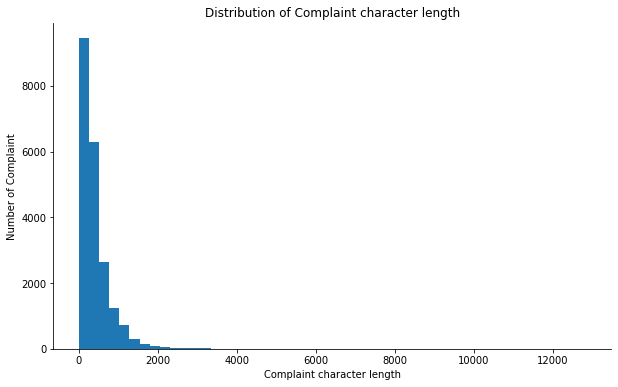

In [ ]:
plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_text.complaints_POS_removed]
plt.hist(doc_lens, bins = 50)
plt.title('Distribution of Complaint character length')
plt.ylabel('Number of Complaint')
plt.xlabel('Complaint character length')
sns.despine()
plt.show();

The above plot shows that in terms of the distribution of the word counts, it is positively skewed.

Below, we show the top 40 words by frequency among all the articles after processing the text.

In [ ]:
stopwords = set(STOPWORDS)
wc = WordCloud(background_color='white', stopwords=stopwords, max_words=40, 
               max_font_size=40, random_state=42).generate(str(df_text['complaints_POS_removed']))
print(wc)

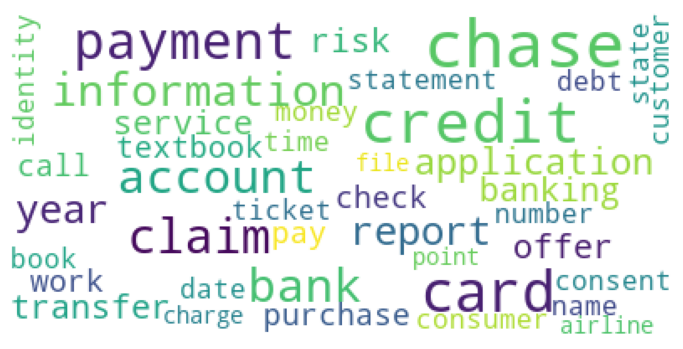

In [ ]:
mpl.rcParams['figure.figsize'] = (12.0,12.0)  
mpl.rcParams['font.size'] = 12            
mpl.rcParams['savefig.dpi'] = 100             
mpl.rcParams['figure.subplot.bottom'] =.1 
fig = plt.figure()
plt.imshow(wc);
plt.axis('off')
plt.show();

In [ ]:
#Removing `-PRON-` from the text corpus
df_text['complaints_fin_ver'] = df_text['complaints_POS_removed'].str.replace('-PRON-', '')
display(df_text.sample(n=5))

,complaints_unclean,complaints_clean,complaints_lemmatize,complaints_POS_removed,complaints_fin_ver
18582,"Prior to making some overseas trips, I consulted the chase.com website to determine if my credit card had foreign transaction fees. \n\nI logged into the secure section of the website to ensure I was accessing my information, and under my credit card account, under the things you can do area, the first item was view my card benefits. When clicking on that, I was taken to a page ( I have the screen shots taken afterward ) that clearly states that there were no foreign transaction fees. \n\nAfter using this card for purchases on my trips, I was charged secure transaction fees totaling about {$40.00} US Dollars. I have two other cards that also do n't have these fees that I could easily have used. \n\nI have since been working directly with Chase, via their secure message system, to reverse these charges. They refuse to acknowledge that their website directs me to this page ( which i have screenshots that it does ) and they claim that the agreement I signed calls for these fees. I asked for a copy of my agreement - they said they do n't have it because I filled out my application online. I have all of these messages. \n\nI asked for a payoff balance so that I could close the card and they refused to provide it. I have these messages as well. \n\nI would like help in forcing them to close my account, and ideally, to refund these foreign transaction fees, that they are falsely advertising on this card. \n\nDespite this, after several secure message exchanges with Chase, they res with Chase",prior making some overseas trips consulted chase website determine credit card foreign transaction fees logged into secure section website ensure accessing information under credit card account under things area first item view card benefits when clicking that taken page have screen shots taken afterward that clearly states that there were foreign transaction fees after using this card purchases trips charged secure transaction fees totaling about dollars have other cards that also have these fees that could easily have used have since been working directly with chase their secure message system reverse these charges they refuse acknowledge that their website directs this page which have screenshots that does they claim that agreement signed calls these fees asked copy agreement they said they have because filled application online have these messages asked payoff balance that could close card they refused provide have these messages well would like help forcing them close account ideally refund these foreign transaction fees that they falsely advertising this card despite this after several secure message exchanges with chase they with chase,prior make some overseas trip consult chase website determine credit card foreign transaction fee log into secure section website ensure access information under credit card account under thing area first item view card benefit when click that take page have screen shot take afterward that clearly state that there be foreign transaction fee after use this card purchase trip charge secure transaction fee total about dollar have other card that also have these fee that could easily have use have since be work directly with chase their secure message system reverse these charge they refuse acknowledge that their website direct this page which have screenshot that do they claim that agreement sign call these fee ask copy agreement they say they have because fill application online have these message ask payoff balance that could close card they refuse provide have these message well would like help force they close account ideally refund these foreign transaction fee that they falsely advertise this card despite this after several secure message exchange with chase they with chase,trip consult chase determine credit card transaction fee log section access information credit card account thing area item vie

Given below are the top unigrams, bigrams and trigrams by frequency among all the complaints after processing the text: 

- **credit**
- **debt** 
- **bank** 
- **loan** 
- **mortgage** 

The above are some of the top words which makes sense given the focus of the complaints.

In [ ]:
def get_top_n_ngram(corpus:str=None, ng_range:tuple=(), 
                     n:int=0) -> list:
    """
    Get top `n` ngrams from a given corpus.
    Args:
        corpus:str      | Default value None
        ng_range:tuple  | Default value ()
        n:int           | Default value 0
    Returns:
        words_freq:list 
    """
    if ng_range:
        vec = CountVectorizer(ngram_range=ng_range, stop_words='english').fit(corpus)
    else:
        vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
# Extract and plot top 30 unigrams

common_words = get_top_n_ngram(corpus=df_text['complaints_fin_ver'].values.astype('U'), n=30)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])
display(df2.head(10))

fig = go.Figure([go.Bar(x=df2['unigram'], y=df2['count'])])
fig.update_layout(title=go.layout.Title(
    text="Top 30 unigrams in complaint text after removing stop words and lemmatization"))
fig.show();

,unigram,count
0,chase,49139
1,account,42814
2,credit,34181
3,bank,28440
4,card,26601
5,payment,21263
6,time,16172
7,charge,15847
8,money,11970
9,check,11686


In [ ]:
# Extract and plot top 30 bigrams

common_words = get_top_n_ngram(corpus=df_text['complaints_fin_ver'].values.astype('U'), 
                               ng_range=(2, 2), n=30)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])
display(df3.head(10))

fig = go.Figure([go.Bar(x=df3['bigram'], y=df3['count'])])
fig.update_layout(title=go.layout.Title(
    text="Top 30 bigrams in complaint text after removing stop words and lemmatization"))
fig.show();

,bigram,count
0,credit card,12667
1,chase bank,4294
2,credit report,4108
3,customer service,3084
4,check account,3053
5,chase credit,2820
6,bank account,2621
7,account chase,2527
8,chase account,2232
9,account account,1991


In [ ]:
# Extract and plot top 30 trigrams

common_words = get_top_n_ngram(corpus=df_text['complaints_fin_ver'].values.astype('U'), 
                               ng_range=(3, 3), n=30)
df4 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])
df4.head(10)

fig = go.Figure([go.Bar(x=df4['trigram'], y=df4['count'])])
fig.update_layout(title=go.layout.Title(
    text="Top 30 trigrams in complaint text after removing stop words and lemmatization"))
fig.show();

## **6. Topic Modeling with TF-IDF Vectorization and NMF**

### 6.1 Vectorize Raw Texts to TF-IDF Feature Matrix

Here:

- `max_df` is used for removing terms that appear too frequently, also known as "corpus-specific stop words". `max_df = 0.95` means "ignore terms that appear in more than 95% of the complaints"

- `min_df` is used for removing terms that appear too infrequently. `min_df = 2` means "ignore terms that appear in less than 2 complaints"

In [ ]:
tfidf_vec = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

Create a document term matrix using `fit_transform()`. The contents of a document term matrix are tuples of `(complaint_id,token_id)` TF-IDF score such that those tuples that are absent have a score of 0.

In [ ]:
doc_mat = tfidf_vec.fit_transform(df_text['complaints_fin_ver'])

### 6.2 Find Optimal Number of Topic with NMF 

The Non-Negative Matrix Factorization (NMF) is an unsupervised technique wherein high dimensional (word) vectors are decomposed (or factorized) into lower-dimensional (lower-rank) representations. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

We will use a **coherence model** to automatically select the best number of topics.

In [ ]:
# Use Gensim's NMF to get the best num of topics via coherence score
texts = df_text['complaints_fin_ver']
dataset = [d.split() for d in texts]

In [ ]:
# Create a Gensim dictionary, i.e., a mapping between 
# words and their integer id
dictionary = Dictionary(dataset)

In [ ]:
# Filter out extremes to limit the number of features
dictionary.filter_extremes(no_below=3, no_above=0.85, keep_n=5000)

In [ ]:
# Create the bag-of-words format => list of tuples with 
# each tuple being (token_id, token_count)
corpus = [dictionary.doc2bow(text) for text in dataset]

In [ ]:
# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 10, 1))

In [ ]:
# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []
for num in topic_nums:

    NMF = nmf.Nmf(corpus=corpus, num_topics=num, id2word=dictionary, chunksize=2000, 
              passes=5, kappa=.1, minimum_probability=0.01, w_max_iter=300, 
              w_stop_condition=0.0001, h_max_iter=100, h_stop_condition=0.001, 
              eval_every=10, normalize=True, random_state=42)
    
    # Run the coherence model to get the score
    cm = CoherenceModel(model=NMF, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_scores.append(round(cm.get_coherence(), 5))

In [ ]:
# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]
print(best_num_topics)

5


### 6.3 Manual Topic Modeling with NMF

With the above `CoherenceModel` we got the best number of topics as 5.Now, all we need to do is run the model. The only parameter that is required is the number of components i.e. the number of topics we want. *This is the most crucial part in any topic modeling process and will greatly affect how good your final topics are.*

In [ ]:
nmf_model = decomp.NMF(n_components=5,random_state=40)
nmf_model.fit(doc_mat)
print()
print(len(tfidf_vec.get_feature_names()))

NMF(n_components=5, random_state=40)


6461


In [ ]:
# Print the top word of a sample component
single_topic = nmf_model.components_[0]
single_topic.argsort()
top_word_indices = single_topic.argsort()[-10:]
for index in top_word_indices:
    print(tfidf_vec.get_feature_names()[index])

array([   0, 3093, 3094, ...,  947,  472,   46])

number
transaction
branch
fund
chase
deposit
money
check
bank
account


In [ ]:
# Print Top 15 words for each of the topics
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf_vec.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['customer', 'claim', 'day', 'business', 'transfer', 'number', 'transaction', 'branch', 'fund', 'chase', 'deposit', 'money', 'check', 'bank', 'account']


THE TOP 15 WORDS FOR TOPIC #1
['balance', 'letter', 'application', 'year', 'limit', 'debt', 'information', 'score', 'company', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']


THE TOP 15 WORDS FOR TOPIC #2
['foreclosure', 'bank', 'sale', 'document', 'house', 'time', 'rate', 'letter', 'year', 'property', 'chase', 'modification', 'home', 'mortgage', 'loan']


THE TOP 15 WORDS FOR TOPIC #3
['fee', 'company', 'refund', 'statement', 'time', 'service', 'claim', 'fraud', 'merchant', 'purchase', 'transaction', 'chase', 'card', 'dispute', 'charge']


THE TOP 15 WORDS FOR TOPIC #4
['year', 'credit', 'mortgage', 'account', 'day', 'date', 'fee', 'chase', 'auto', 'time', 'pay', 'statement', 'month', 'balance', 'payment']




In [ ]:
# Creating the best topic for each complaint
topic_results = nmf_model.transform(doc_mat)
topic_results[0].round(2)
topic_results[0].argmax()
topic_results.argmax(axis=1)

array([0.03, 0.01, 0.02, 0.01, 0.01])

0

array([0, 1, 1, ..., 3, 4, 4])

In [ ]:
# Assign the best topic to each of the complaints in 
# `Topic` column
df_text['Topic'] = topic_results.argmax(axis=1)

In [ ]:
df_text.head()

,complaints_unclean,complaints_clean,complaints_lemmatize,complaints_POS_removed,complaints_fin_ver,Topic
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning name appreciate could help stop chase bank cardmember services wrote chase asking debt verification what they sent statement which acceptable asking bank validate debt instead been receiving mail every month from them attempting collect debt have right know this information consumer chase account thanks advance your help,good morning name appreciate could help stop chase bank cardmember services write chase ask debt verification what they send statement which acceptable ask bank validate debt instead be receive mail every month from they attempt collect debt have right know this information consumer chase account thank advance your help,morning name appreciate chase bank cardmember debt verification statement ask bank debt mail month debt information consumer chase account help,morning name appreciate chase bank cardmember debt verification statement ask bank debt mail month debt information consumer chase account help,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,upgraded card told agent upgrade anniversary date would change turned agent giving wrong information order upgrade account changed anniversary date from without consent recording agent misled,upgrade card tell agent upgrade anniversary date would change turn agent give wrong information order upgrade account change anniversary date from without consent recording agent mislead,card tell agent date information order upgrade account change date consent agent mislead,card tell agent date information order upgrade account change date consent agent mislead,1
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card reported however fraudulent application have been submitted identity without consent fraudulently obtain services extend credit without verifying identity applicant,chase card report however fraudulent application have be submit identity without consent fraudulently obtain service extend credit without verify identity applicant,card report application identity consent service credit identity applicant,card report application identity consent service credit identity applicant,1
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitl

In [ ]:
# Print the first 5 complaints for each of the topics
df_dc=df_text.groupby('Topic').head(5)
df_dc.sort_values('Topic')

,complaints_unclean,complaints_clean,complaints_lemmatize,complaints_POS_removed,complaints_fin_ver,Topic
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning name appreciate could help stop chase bank cardmember services wrote chase asking debt verification what they sent statement which acceptable asking bank validate debt instead been receiving mail every month from them attempting collect debt have right know this information consumer chase account thanks advance your help,good morning name appreciate could help stop chase bank cardmember services write chase ask debt verification what they send statement which acceptable ask bank validate debt instead be receive mail every month from they attempt collect debt have right know this information consumer chase account thank advance your help,morning name appreciate chase bank cardmember debt verification statement ask bank debt mail month debt information consumer chase account help,morning name appreciate chase bank cardmember debt verification statement ask bank debt mail month debt information consumer chase account help,0
4,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase 2 times they told him i should call not him to verify the check owner he is out the country most the time date happen XX/XX/2018 check number XXXX claim number is XXXX with chase,grand give check deposit into chase account after fund clear chase bank closed account never paid money they said they need speek with grand check clear money taking chase bank refuse money grand called chase times they told should call verify check owner country most time date happen check number claim number with chase,grand give check deposit into chase account after fund clear chase bank close account never pay money they say they need speek with grand check clear money take chase bank refuse money grand call chase time they tell should call verify check owner country most time date happen check number claim number with chase,check deposit chase account fund bank account money check money bank money call chase time check owner country time date check number claim number chase,check deposit chase account fund bank account money check money bank money call chase time check owner country time date check number claim number chase,0
6,"With out notice J.P. Morgan Chase restricted my account by my debit card Tuesday XX/XX/2019. On Thursday XX/XX/2019 I went into A branch after being advised by a customer service representative that my account would actually be closed. I went into the branch to see how I can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned. The bank associate and the customer service representative assured me that the funds would Post but they may take an additional business day. That Saturday I attempted to go inside of a branch yet again to retrieve my funds that actually did post on Friday, XX/XX/2019. Upon looking at my account I realize that the funds have been reversed and no longer were present on my current statement. Ive been called and I was told that it may take two business day stating Tuesday, XX/XX/XXXX would be the date that my funds would be available to withdraw from a bank teller only. Now, Chase is informing me that I will be mailed

In [ ]:
# Create a dictionary of topic names and 
# topics, i.e., topic number
topic_names = {
    0: "Bank Account Services", 
    1: "Credit/Prepaid Card", 
    2: "Others", 
    3: "Theft/Dispute Reporting", 
    4: "Mortgage/Loan"
}

In [ ]:
# Replace Topics with Topic Names
df_text['Topic'] = df_text['Topic'].map(topic_names)

In [ ]:
display(df_text.head())

,complaints_unclean,complaints_clean,complaints_lemmatize,complaints_POS_removed,complaints_fin_ver,Topic
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning name appreciate could help stop chase bank cardmember services wrote chase asking debt verification what they sent statement which acceptable asking bank validate debt instead been receiving mail every month from them attempting collect debt have right know this information consumer chase account thanks advance your help,good morning name appreciate could help stop chase bank cardmember services write chase ask debt verification what they send statement which acceptable ask bank validate debt instead be receive mail every month from they attempt collect debt have right know this information consumer chase account thank advance your help,morning name appreciate chase bank cardmember debt verification statement ask bank debt mail month debt information consumer chase account help,morning name appreciate chase bank cardmember debt verification statement ask bank debt mail month debt information consumer chase account help,Bank Account Services
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,upgraded card told agent upgrade anniversary date would change turned agent giving wrong information order upgrade account changed anniversary date from without consent recording agent misled,upgrade card tell agent upgrade anniversary date would change turn agent give wrong information order upgrade account change anniversary date from without consent recording agent mislead,card tell agent date information order upgrade account change date consent agent mislead,card tell agent date information order upgrade account change date consent agent mislead,Credit/Prepaid Card
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card reported however fraudulent application have been submitted identity without consent fraudulently obtain services extend credit without verifying identity applicant,chase card report however fraudulent application have be submit identity without consent fraudulently obtain service extend credit without verify identity applicant,card report application identity consent service credit identity applicant,card report application identity consent service credit identity applicant,Credit/Prepaid Card
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and co

## **7. Build Supervised Model to Classify New Complaints** 

We have analyzed and preprocessed raw text data (consumer complaints) and clustered them into 5 topics using NMF technique. In this section we will use supervised machine learning to classify new consumer complaints to the appropriate topic. 

Since we will be using supervised learning technique, we have to convert the topic names to numbers as ML algorithms are applicable to numbers *only*.

In [ ]:
Topic_names = {
    "Bank Account Services": 0, 
    "Credit/Prepaid Card": 1, 
    "Others": 2, 
    "Theft/Dispute Reporting": 3, 
    "Mortgage/Loan":4
}

df_text['Topic'] = df_text['Topic'].map(Topic_names)

In [ ]:
display(df_text.head())

,complaints_unclean,complaints_clean,complaints_lemmatize,complaints_POS_removed,complaints_fin_ver,Topic
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning name appreciate could help stop chase bank cardmember services wrote chase asking debt verification what they sent statement which acceptable asking bank validate debt instead been receiving mail every month from them attempting collect debt have right know this information consumer chase account thanks advance your help,good morning name appreciate could help stop chase bank cardmember services write chase ask debt verification what they send statement which acceptable ask bank validate debt instead be receive mail every month from they attempt collect debt have right know this information consumer chase account thank advance your help,morning name appreciate chase bank cardmember debt verification statement ask bank debt mail month debt information consumer chase account help,morning name appreciate chase bank cardmember debt verification statement ask bank debt mail month debt information consumer chase account help,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,upgraded card told agent upgrade anniversary date would change turned agent giving wrong information order upgrade account changed anniversary date from without consent recording agent misled,upgrade card tell agent upgrade anniversary date would change turn agent give wrong information order upgrade account change anniversary date from without consent recording agent mislead,card tell agent date information order upgrade account change date consent agent mislead,card tell agent date information order upgrade account change date consent agent mislead,1
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card reported however fraudulent application have been submitted identity without consent fraudulently obtain services extend credit without verifying identity applicant,chase card report however fraudulent application have be submit identity without consent fraudulently obtain service extend credit without verify identity applicant,card report application identity consent service credit identity applicant,card report application identity consent service credit identity applicant,1
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitl

In [ ]:
train_data = df_text.loc[:, ["complaints_unclean", "Topic"]]
display(train_data.sample(n=6))

,complaints_unclean,Topic
1426,"My husband and I had a joint checking account with Chase Bank for over 20 years. \nThe account was opened while we lived in the XXXX area. After moving to XXXX XXXX XXXX years ago, we opened new bank accounts with a local bank because Chase did not have branches in XXXX XXXX. We had an automatic monthly life insurance premium deducted from the Chase account and automatic monthly deposits for my husband 's small pensions. We accessed this account infrequently because there was no need to. It was simply easier to leave this account in place than close it and change the automatic deduction/deposits. \n\nIn early XX/XX/XXXX my husband noticed that XXXX separate withdrawals had occurred, XX/XX/XXXX in the amount of {$790.00} and XX/XX/XXXX in the amount of {$1500.00}, neither of which we authorized. My husband contacted Chase to report the theft and was told someone would look into it, and in the meantime, a temporary credit would be issued. A few days later in XX/XX/XXXX while talking again with Chase, my husband was told two additional withdrawals had occurred, {$1.00} on XX/XX/XXXX and {$1500.00} on XX/XX/XXXX. My husband had been told by Chase that amounts taken fraudulently and reported within 60 days would be reimbursed. \n\nWhile reviewing our Chase account yesterday, we noticed that {$1.00}, {$790.00}, and {$1500.00} had been reimbursed in our account, but the {$1500.00} taken in XX/XX/XXXX had not. The theft of {$1500.00} had been reported on XX/XX/XXXX, 52 days after it had occurred, within the 60 day window. \n\nI called Chase XX/XX/XXXX to ask about the un-reimbursed {$1500.00} and, incredibly, was told the 60 day window started with the first theft that occurred in XX/XX/XXXX. That the thief was clever enough to withdraw the unnoticeable amount of {$1.00} and wait another three months before withdrawing fraudulently again, it was, according to Chase, our misfortune that the 60 day window had passed. \n\nWe depend on our bank to safeguard our assets and not simply give our money to anyone who asks. We also expect our bank to reimburse for fraudulent activity when reported promptly. Chase 's 60-day window that starts with the first occurrence is arbitrary and harmful to it's customers. My husband was told that after an incidence of fraud is reported, the bank will neither investigate further fraudulent activity nor reimburse the loss ( es ) resulting from fraud. In other words, a thief who repeatedly accesses an account will simply be allowed to do so at a Chase bank. \n\nIn our case, we were victims twice - the first by the unknown person who accessed our account, and by Chase, who has refused to reimburse us for the {$1500.00} loss.",0
14289,"On XX/XX/2016 my home was sold unlawfully at a Sheriff 's sale by HSBC Bank USA , National Association, as Indenture Trustee, of the XXXX Securitization Trust XXXX Callable Mortgage-Backed Notes, Series XXXX The foreclosure sale was illegally authorized by HSBC Bank USA and XXXX before the loss mitigation process was completed. Employees of XXXX have admitted verbally that there is no proof that the foreclosure should have taken place since the loss mitigation process was not completed. I was assigned a single point of contact ( SPOC ) at XXXX to manage the loss mitigation process since I was unemployed and recently started my own company to earn income to support a loan modification plan. Prior to the sale of the home, XXXX assigned a new SPOC, but the home was sold prior to initiating a discussion with this person. I submitted all required information to XXXX to support the loss mitigation process and was told that I would be informed of the decision. This was never done. To date, no decision was reached regarding the loss mitigation evaluation process and I told that the loss mitigation request was in review and no decision was made. Prior to the sale of the home, the lender, HSBC, was working with a local law firm to sell the home and kept issui

In [ ]:
# Get vector count 
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train_data.complaints_unclean)

# Save word vector to disk 
pickle.dump(count_vect.vocabulary_, open("count_vector.pkl","wb"))

In [ ]:
# Transform word vector to TF-IDF vector 
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# Save TF-IDF vector to disk
pickle.dump(tfidf_transformer, open("tfidf.pkl","wb"))

In [ ]:
def train_test_evaluate(estimator=None, name=None, 
                        trainData=None, testData=None, testSize:float=0.3, 
                        randomState:int=42):
    """
    Perform train-test split, train model, test model, and evaluate model performance.
    Args:
        estimator:sklearn.estimator class object    | Default value None
        name:str                                    | Default value None
        trainData:pd.Series or np.array             | Default value None
        testData:pd.Series or np.array              | Default value None
        testSize:float                              | Default value 0.3
        randomState:int                             | Default value 42
    """

    # Perform train-test split with `test_size=0.25`
    X_train, X_test, y_train, y_test = tts(
        trainData, testData, test_size=testSize, random_state=randomState)

    # Create Multinomial Naive Bayes classifier 
    clf = estimator.fit(X_train, y_train)

    # Save model to disk
    model_name = name + ".pkl"
    pickle.dump(clf, open(model_name, "wb"))
    print('Model created and saved to disc!')

    # Manual creation of the topic names as a list
    target_names = [
    "Bank Account Services", 
    "Credit/Prepaid Card", 
    "Others", 
    "Theft/Dispute Reporting", 
    "Mortgage/Loan"
    ]

    docs_new = """
    I can't get any info from chase about who services my mortgage, who owns it and who has 
    original loan docs
    """
    docs_new = docs_new.split(" ")

    # Load model
    load_cvec = CountVectorizer(vocabulary=pickle.load(open("count_vector.pkl", "rb")))
    load_tfidf = pickle.load(open("tfidf.pkl","rb"))
    load_model = pickle.load(open(model_name,"rb"))
    print('Model loaded from disc!')

    # Test model: Make predictions and evaluate model
    X_new_counts = load_cvec.transform(docs_new)
    X_new_tfidf = load_tfidf.transform(X_new_counts)
    predicted = load_model.predict(X_new_tfidf)
    # print('Target Names: ', target_names[predicted[:]])
    predicted = load_model.predict(X_test)
    result = pd.DataFrame({
        'true_topic': y_test.apply(lambda x: target_names[x]), 
        'predicted_topic': y_test.apply(lambda x: target_names[x]), 
        'true_topic_num': y_test, 
        'predicted_topic_num': predicted
        })
    display(result.head(10))
    print()
   
    conf_mat = confusion_matrix(y_test,predicted)
    print(conf_mat)
    print()
    clf_report = classification_report(
        y_test, predicted, target_names=target_names)
    print(clf_report)

### 7.1 Predictive Classifier 1: Multinomial Naive Bayes 

In [ ]:
clf_mB = MultinomialNB()
train_test_evaluate(estimator=clf_mB, name='nb_model', 
                    trainData=X_train_tfidf, testData=train_data.Topic, 
                    testSize=0.25)

Model created and saved to disc!
Model loaded from disc!


,true_topic,predicted_topic,true_topic_num,predicted_topic_num
10796,Mortgage/Loan,Mortgage/Loan,4,0
16441,Theft/Dispute Reporting,Theft/Dispute Reporting,3,3
16623,Others,Others,2,2
12833,Credit/Prepaid Card,Credit/Prepaid Card,1,1
14844,Theft/Dispute Reporting,Theft/Dispute Reporting,3,3
17572,Others,Others,2,1
4448,Bank Account Services,Bank Account Services,0,0
7409,Bank Account Services,Bank Account Services,0,0
9415,Bank Account Services,Bank Account Services,0,1
3572,Bank Account Services,Bank Account Services,0,0



[[1281   54    6   26    2]
 [ 172 1028    5  111    0]
 [ 138   92  628   14    0]
 [ 248   90    4  799    0]
 [ 201  218   71   73    7]]

                         precision    recall  f1-score   support

  Bank Account Services       0.63      0.94      0.75      1369
    Credit/Prepaid Card       0.69      0.78      0.73      1316
                 Others       0.88      0.72      0.79       872
Theft/Dispute Reporting       0.78      0.70      0.74      1141
          Mortgage/Loan       0.78      0.01      0.02       570

               accuracy                           0.71      5268
              macro avg       0.75      0.63      0.61      5268
           weighted avg       0.74      0.71      0.67      5268



### 7.2 Predictive Classifier 2: Logistic Regression  

In [ ]:
clf_lr = LogisticRegression(random_state=0)
train_test_evaluate(estimator=clf_lr, name='lr_model',
                    trainData=X_train_tfidf, testData=train_data.Topic, 
                    testSize=0.25)

Model created and saved to disc!
Model loaded from disc!


,true_topic,predicted_topic,true_topic_num,predicted_topic_num
10796,Mortgage/Loan,Mortgage/Loan,4,0
16441,Theft/Dispute Reporting,Theft/Dispute Reporting,3,3
16623,Others,Others,2,2
12833,Credit/Prepaid Card,Credit/Prepaid Card,1,1
14844,Theft/Dispute Reporting,Theft/Dispute Reporting,3,3
17572,Others,Others,2,2
4448,Bank Account Services,Bank Account Services,0,0
7409,Bank Account Services,Bank Account Services,0,0
9415,Bank Account Services,Bank Account Services,0,0
3572,Bank Account Services,Bank Account Services,0,0



[[1296   25    8   35    5]
 [  23 1228    9   43   13]
 [  17   14  821   18    2]
 [  50   54   16 1015    6]
 [  16   22   22   22  488]]

                         precision    recall  f1-score   support

  Bank Account Services       0.92      0.95      0.94      1369
    Credit/Prepaid Card       0.91      0.93      0.92      1316
                 Others       0.94      0.94      0.94       872
Theft/Dispute Reporting       0.90      0.89      0.89      1141
          Mortgage/Loan       0.95      0.86      0.90       570

               accuracy                           0.92      5268
              macro avg       0.92      0.91      0.92      5268
           weighted avg       0.92      0.92      0.92      5268



### 7.3 Predictive Classifier 3: Decision Tree  

In [ ]:
clf_dt = DecisionTreeClassifier(random_state=0)
train_test_evaluate(estimator=clf_dt, name='dt_model',
                    trainData=X_train_tfidf, testData=train_data.Topic, 
                    testSize=0.25)

Model created and saved to disc!
Model loaded from disc!


,true_topic,predicted_topic,true_topic_num,predicted_topic_num
10796,Mortgage/Loan,Mortgage/Loan,4,4
16441,Theft/Dispute Reporting,Theft/Dispute Reporting,3,3
16623,Others,Others,2,2
12833,Credit/Prepaid Card,Credit/Prepaid Card,1,1
14844,Theft/Dispute Reporting,Theft/Dispute Reporting,3,3
17572,Others,Others,2,0
4448,Bank Account Services,Bank Account Services,0,3
7409,Bank Account Services,Bank Account Services,0,2
9415,Bank Account Services,Bank Account Services,0,0
3572,Bank Account Services,Bank Account Services,0,0



[[1094   64   48  131   32]
 [  65 1059   31  123   38]
 [  53   26  696   53   44]
 [ 118  100   39  851   33]
 [  31   31   39   39  430]]

                         precision    recall  f1-score   support

  Bank Account Services       0.80      0.80      0.80      1369
    Credit/Prepaid Card       0.83      0.80      0.82      1316
                 Others       0.82      0.80      0.81       872
Theft/Dispute Reporting       0.71      0.75      0.73      1141
          Mortgage/Loan       0.75      0.75      0.75       570

               accuracy                           0.78      5268
              macro avg       0.78      0.78      0.78      5268
           weighted avg       0.79      0.78      0.78      5268



### 7.4 Predictive Classifier 4: Random Forest


In [ ]:
clf_rf = RandomForestClassifier(random_state=0)
train_test_evaluate(estimator=clf_rf, name='rf_model',
                    trainData=X_train_tfidf, testData=train_data.Topic, 
                    testSize=0.25)

Model created and saved to disc!
Model loaded from disc!


,true_topic,predicted_topic,true_topic_num,predicted_topic_num
10796,Mortgage/Loan,Mortgage/Loan,4,0
16441,Theft/Dispute Reporting,Theft/Dispute Reporting,3,3
16623,Others,Others,2,2
12833,Credit/Prepaid Card,Credit/Prepaid Card,1,1
14844,Theft/Dispute Reporting,Theft/Dispute Reporting,3,3
17572,Others,Others,2,2
4448,Bank Account Services,Bank Account Services,0,0
7409,Bank Account Services,Bank Account Services,0,0
9415,Bank Account Services,Bank Account Services,0,0
3572,Bank Account Services,Bank Account Services,0,0



[[1262   59    7   39    2]
 [  64 1161    6   80    5]
 [  44   41  769   14    4]
 [ 119   99   19  900    4]
 [  91   92   78   65  244]]

                         precision    recall  f1-score   support

  Bank Account Services       0.80      0.92      0.86      1369
    Credit/Prepaid Card       0.80      0.88      0.84      1316
                 Others       0.87      0.88      0.88       872
Theft/Dispute Reporting       0.82      0.79      0.80      1141
          Mortgage/Loan       0.94      0.43      0.59       570

               accuracy                           0.82      5268
              macro avg       0.85      0.78      0.79      5268
           weighted avg       0.83      0.82      0.82      5268



## **8. Conclusions** 

1. Out of all the four models compared, *without any kind of model optimization*, the performance of the Logistic Regression algorithm, in terms of F1 score, precision and recall metrics, is the best for all the 5 topics.


2. The *unoptimized* performances of the Decision Tree and Random Forest classifiers come in second and third positions, respectively. The Decision Tree classifier is found to have a very balanced performance w.r.t all the 5 classes.


3. The Multinomial Naive Bayes algorithms in comparison to the other 3 algorithms performs very poorly w.r.t the **Mortgage/Loan** topic.